In [ ]:


# !pip install tensorflow==2.15
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential, Model
from keras.utils import Sequence
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Conv1D, Conv1DTranspose,AveragePooling1D, MaxPooling1D,UpSampling1D,LeakyReLU, ReLU, concatenate, Dropout,BatchNormalization,Activation
from pathlib import Path
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import h5py
import random
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from scipy.stats import pearsonr
from keras.callbacks import ReduceLROnPlateau
from google.colab import drive
import os
import time
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
tf.__version__

'2.19.0'

In [ ]:
Train_Address = "/content/drive/MyDrive/Spike_Restoration/Main_Work_not_Proposal/Splitted_Data_for_paper1/SNDR/Train.mat"
Info = scipy.io.whosmat(Train_Address)
print(Info)
datam = scipy.io.loadmat(Train_Address)
Train_Data_Y_1 = np.asarray(datam ['Data'])

Val_Address = "/content/drive/MyDrive/Spike_Restoration/Main_Work_not_Proposal/Splitted_Data_for_paper1/SNDR/Val.mat"
Info = scipy.io.whosmat(Val_Address)
print(Info)
datam = scipy.io.loadmat(Val_Address)
Val_Data_Y = np.asarray(datam ['Data'])

Test_Address = "/content/drive/MyDrive/Spike_Restoration/Main_Work_not_Proposal/Splitted_Data_for_paper1/SNDR/Test.mat"
Info = scipy.io.whosmat(Test_Address)
print(Info)
datam = scipy.io.loadmat(Test_Address)
Test_Data_Y = np.asarray(datam ['Data'])

In [ ]:
Train_Address = "/content/drive/MyDrive/Spike_Restoration/Main_Work_not_Proposal/Data_for_paper3/WHT_2_Train.mat"
Info = scipy.io.whosmat(Train_Address)
print(Info)
datam = scipy.io.loadmat(Train_Address)
Train_Data_X_1 = np.asarray(datam ['X'])

Val_Address = "/content/drive/MyDrive/Spike_Restoration/Main_Work_not_Proposal/Data_for_paper3/WHT_2_Val.mat"
Info = scipy.io.whosmat(Val_Address)
print(Info)
datam = scipy.io.loadmat(Val_Address)
Val_Data_X = np.asarray(datam ['X'])

Test_Address = "/content/drive/MyDrive/Spike_Restoration/Main_Work_not_Proposal/Data_for_paper3/WHT_2_Test.mat"
Info = scipy.io.whosmat(Test_Address)
print(Info)
datam = scipy.io.loadmat(Test_Address)
Test_Data_X = np.asarray(datam ['X'])

In [ ]:
Sigma = 0.05
M = 16
rng = np.random.randn(*Train_Data_X_1.shape)
scale = Sigma * (Train_Data_X_1.max(axis=1) - Train_Data_X_1.min(axis=1))[:, None]
Train_Data_X_1 = Train_Data_X_1 + scale * rng

rng = np.random.randn(*Test_Data_X.shape)
scale = Sigma * (Test_Data_X.max(axis=1) - Test_Data_X.min(axis=1))[:, None]
Test_Data_X = Test_Data_X + scale * rng
scipy.io.savemat('/content/drive/MyDrive/Spike_Restoration/Main_Work_not_Proposal/Data_for_paper3/Sym4_'+str(int(M))+'_Noisy_Test.mat', {'X': Test_Data_X})

rng = np.random.randn(*Val_Data_X.shape)
scale = Sigma * (Val_Data_X.max(axis=1) - Val_Data_X.min(axis=1))[:, None]
Val_Data_X = Val_Data_X + scale * rng

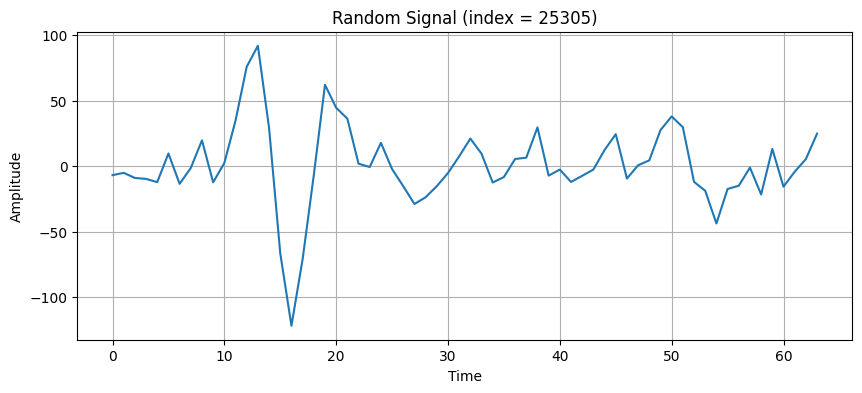

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# pick a random sample index
# idx = np.random.randint(0, Train_Data_X_1.shape[0])
idx = 25305
# extract the signal
signal = Test_Data_X[idx]

# plot it
plt.figure(figsize=(10,4))
plt.plot(signal)
plt.title(f"Random Signal (index = {idx})")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()


In [ ]:
def unet(input_size):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv1D(32*2, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    tmp   = conv1
    conv1 = Conv1D(32*2, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    conv1 = conv1 + tmp
    pool1 = MaxPooling1D(pool_size= 2)(conv1)

    conv2 = Conv1D(64*2, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    tmp   = conv2
    conv2 = Conv1D(64*2, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    conv2 = conv2 + tmp
    pool2 = MaxPooling1D(pool_size=2)(conv2)

    conv3 = Conv1D(128*2, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    tmp   = conv3
    conv3 = Conv1D(128*2, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv3 = conv3 + tmp

    # Decoder
    up4 = Conv1DTranspose(64*2, 2, strides=2, padding='same')(conv3)
    merge4 = up4 #concatenate([conv2, up4])
    conv4 = Conv1D(64*2, 3, activation='relu', padding='same')(merge4)
    conv4 = BatchNormalization()(conv4)
    tmp   = conv4
    conv4 = Conv1D(64*2, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = conv4 + tmp

    up5 = Conv1DTranspose(32*2, 2, strides=2, padding='same')(conv4)
    merge5 = up5 #concatenate([conv1, up5])
    conv5 = Conv1D(32*2, 3, activation='relu', padding='same')(merge5)
    conv5 = BatchNormalization()(conv5)
    tmp   = conv5
    conv5 = Conv1D(32*2, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = conv5 + tmp

    # Output
    outputs = Conv1D(1, 1, activation='linear')(conv5)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
N = 64
input_size = (N, 1)
model = unet(input_size)
# model.summary()

Optimizer = keras.optimizers.SGD(learning_rate=1e-5)
model.compile(optimizer = Optimizer, loss = 'MSE',
              metrics = ['RootMeanSquaredError'])
early_stopping = EarlyStopping(patience=20, monitor = 'val_RootMeanSquaredError',
                          mode='min', restore_best_weights=True)
model_checkpoint = ModelCheckpoint(filepath = '/content/drive/MyDrive/Spike_Restoration/Main_Work_not_Proposal/Sym4_CNN_16_Den2.keras',
   monitor = 'val_RootMeanSquaredError', save_best_only=True)
#%%time
X_train = np.expand_dims(Train_Data_X_1, axis=2)
Y_train = np.expand_dims(Train_Data_Y_1, axis=2)
X_val = np.expand_dims(Val_Data_X, axis=2)
Y_val = np.expand_dims(Val_Data_Y, axis=2)

history = model.fit((X_train),(Y_train),
                    batch_size = 32,
                    epochs=500*2,
                    validation_data=(X_val, Y_val),
                    callbacks=[early_stopping,
                                model_checkpoint])

Epoch 1/1000
4516/4516 ━━━━━━━━━━━━━━━━━━━━ 39s 7ms/step - RootMeanSquaredError: 25.2150 - loss: 690.1310 - val_RootMeanSquaredError: 26.0038 - val_loss: 676.1970
Epoch 2/1000
4516/4516 ━━━━━━━━━━━━━━━━━━━━ 29s 6ms/step - RootMeanSquaredError: 15.0782 - loss: 227.3732 - val_RootMeanSquaredError: 25.4754 - val_loss: 648.9966
Epoch 3/1000
4516/4516 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - RootMeanSquaredError: 14.6516 - loss: 214.6731 - val_RootMeanSquaredError: 25.2444 - val_loss: 637.2796
Epoch 4/1000
4516/4516 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - RootMeanSquaredError: 14.3429 - loss: 205.7228 - val_RootMeanSquaredError: 25.5993 - val_loss: 655.3241
Epoch 5/1000
4516/4516 ━━━━━━━━━━━━━━━━━━━━ 27s 6ms/step - RootMeanSquaredError: 14.0033 - loss: 196.1009 - val_RootMeanSquaredError: 25.3164 - val_loss: 640.9186
Epoch 6/1000
4516/4516 ━━━━━━━━━━━━━━━━━━━━ 26s 6ms/step - RootMeanSquaredError: 13.6377 - loss: 185.9950 - val_RootMeanSquaredError: 25.0068 - val_loss: 625.3424
Epoch 7/1000
4516/4516

In [ ]:
def sndr(x0,x):
  return 20*np.log10(np.linalg.norm(x0)/np.linalg.norm(x-x0))


model = keras.models.load_model("/content/drive/MyDrive/Spike_Restoration/Main_Work_not_Proposal/WHT_CNN_16.keras")
# model.summary()
X_Test = np.expand_dims(Test_Data_X, axis=2)

Time0 = time.time()
prediction = model.predict(X_Test) #Y for AE, X for U-Net
Time1 = time.time()
RunTime = Time1 - Time0
RunTimePerSpike = RunTime/len(prediction)

SNDR = np.zeros([Test_Data_Y.shape[0]])
# There's much difference between inputting matrices and tensors. Be careful.
for i in range (0,Test_Data_X.shape[0]):  #Output SNDR
  SNDR[i] = sndr(Test_Data_Y[i], prediction[i,:,0])
print(np.mean(SNDR), np.std(SNDR))


for i in range (0,Test_Data_X.shape[0]):  #Input SNDR
  SNDR[i] = sndr(Test_Data_Y[i], Test_Data_X[i])
print(np.mean(SNDR), np.std(SNDR))
print(RunTimePerSpike*1000)

M = 16
# scipy.io.savemat('/content/drive/MyDrive/Spike_Restoration/Main_Work_not_Proposal/Data_for_paper3/Sym4_CNN_'+str(M)+'_Den_Test_Rec.mat', {'prediction': prediction})